<title>Data understanding</title>

<h1>Data understanding</h1>

In [1]:
pip install pyspark


[notice] A new release of pip available: 22.2 -> 23.2.1
[notice] To update, run: C:\Users\Blake\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:

import pyspark
from pyspark.sql.functions import when, col, count, rand, sum, concat, lit, array,size, concat_ws
from pyspark.ml.fpm import FPGrowth, PrefixSpan
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Itteration 4').getOrCreate()

<h2>Import datasets</h2>

In [4]:
app_raw = spark.read.csv('F:/University/Postgrad/2023 Sem 2/INFOSYS 722/Assignments/Data used/application_data.csv', header=True, inferSchema=True)
prev_raw = spark.read.csv("F:/University/Postgrad/2023 Sem 2/INFOSYS 722/Assignments/Data used/bureau.csv", header=True, inferSchema=True)

In [5]:
app_raw.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+------------

In [6]:
prev_raw.show()

+----------+------------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+---------------+------------------+-----------+
|SK_ID_CURR|SK_ID_BUREAU|CREDIT_ACTIVE|CREDIT_CURRENCY|DAYS_CREDIT|CREDIT_DAY_OVERDUE|DAYS_CREDIT_ENDDATE|DAYS_ENDDATE_FACT|AMT_CREDIT_MAX_OVERDUE|CNT_CREDIT_PROLONG|AMT_CREDIT_SUM|AMT_CREDIT_SUM_DEBT|AMT_CREDIT_SUM_LIMIT|AMT_CREDIT_SUM_OVERDUE|    CREDIT_TYPE|DAYS_CREDIT_UPDATE|AMT_ANNUITY|
+----------+------------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+---------------+------------------+-----------+
|    215354|     5714462|       Closed|     currency 1|       -497|                 0|             -153.0|           -153

<h2>Data prerperation</h2>

In [7]:
app_df = app_raw[['SK_ID_CURR','NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','OCCUPATION_TYPE','CNT_FAM_MEMBERS','WEEKDAY_APPR_PROCESS_START',
'HOUR_APPR_PROCESS_START','ORGANIZATION_TYPE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']]
app_df.show()

+----------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+-----------------+---------------+-----------+---------------+---------------+--------------------------+-----------------------+--------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|SK_ID_CURR|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_TYPE_SUITE|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|DAYS_REGISTRATION|DAYS_ID_PUBLISH|OWN_CAR_AGE|OCCUPATION_TYPE|CNT_FAM_MEMBERS|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|   ORGANIZATION_TYPE|AMT_REQ_CREDIT

<h3>Find completness</h3>

In [8]:
def get_completeness(df_given):
    # Calculate completeness for each column
    completeness_data = []

    for column in df_given.columns:
        non_null_count = df_given.filter(col(column).isNotNull()).count()
        total_count = df_given.count()
        completeness = (non_null_count / total_count) * 100
        completeness_data.append((column, completeness))

    # Create a DataFrame to store the completeness results
    return spark.createDataFrame(completeness_data, ["Column", "Completeness"])


In [9]:
app_df_completness = get_completeness(app_df)
prev_raw_completness = get_completeness(prev_raw)

In [10]:
app_df_completness.show(50)
prev_raw_completness.show()

+--------------------+------------------+
|              Column|      Completeness|
+--------------------+------------------+
|          SK_ID_CURR|             100.0|
|  NAME_CONTRACT_TYPE|             100.0|
|         CODE_GENDER|             100.0|
|        FLAG_OWN_CAR|             100.0|
|     FLAG_OWN_REALTY|             100.0|
|        CNT_CHILDREN|             100.0|
|    AMT_INCOME_TOTAL|             100.0|
|          AMT_CREDIT|             100.0|
|         AMT_ANNUITY| 99.99609770057006|
|     AMT_GOODS_PRICE| 99.90959672987307|
|     NAME_TYPE_SUITE| 99.57985242804322|
|    NAME_INCOME_TYPE|             100.0|
| NAME_EDUCATION_TYPE|             100.0|
|  NAME_FAMILY_STATUS|             100.0|
|   NAME_HOUSING_TYPE|             100.0|
|          DAYS_BIRTH|             100.0|
|       DAYS_EMPLOYED|             100.0|
|   DAYS_REGISTRATION|             100.0|
|     DAYS_ID_PUBLISH|             100.0|
|         OWN_CAR_AGE|34.009189915157506|
|     OCCUPATION_TYPE| 68.65445463

<h3>Fill incomplete columns</h3>

In [11]:
fill_values = {"NAME_TYPE_SUITE" : "None",
                "OCCUPATION_TYPE" : "Unknown",
                'OWN_CAR_AGE' : 0,'CNT_FAM_MEMBERS' : 0,
                'AMT_ANNUITY' : 0,'AMT_GOODS_PRICE' : 0,
                'AMT_REQ_CREDIT_BUREAU_HOUR' : 0,
                'AMT_REQ_CREDIT_BUREAU_DAY' : 0,
                'AMT_REQ_CREDIT_BUREAU_WEEK' : 0,
                'AMT_REQ_CREDIT_BUREAU_MON' : 0,
                'AMT_REQ_CREDIT_BUREAU_QRT' : 0,
                'AMT_REQ_CREDIT_BUREAU_YEAR' : 0}
app_df_complete = app_df.fillna(fill_values)
completness_check = get_completeness(app_df_complete)

In [12]:
completness_check.show(50)

+--------------------+------------+
|              Column|Completeness|
+--------------------+------------+
|          SK_ID_CURR|       100.0|
|  NAME_CONTRACT_TYPE|       100.0|
|         CODE_GENDER|       100.0|
|        FLAG_OWN_CAR|       100.0|
|     FLAG_OWN_REALTY|       100.0|
|        CNT_CHILDREN|       100.0|
|    AMT_INCOME_TOTAL|       100.0|
|          AMT_CREDIT|       100.0|
|         AMT_ANNUITY|       100.0|
|     AMT_GOODS_PRICE|       100.0|
|     NAME_TYPE_SUITE|       100.0|
|    NAME_INCOME_TYPE|       100.0|
| NAME_EDUCATION_TYPE|       100.0|
|  NAME_FAMILY_STATUS|       100.0|
|   NAME_HOUSING_TYPE|       100.0|
|          DAYS_BIRTH|       100.0|
|       DAYS_EMPLOYED|       100.0|
|   DAYS_REGISTRATION|       100.0|
|     DAYS_ID_PUBLISH|       100.0|
|         OWN_CAR_AGE|       100.0|
|     OCCUPATION_TYPE|       100.0|
|     CNT_FAM_MEMBERS|       100.0|
|WEEKDAY_APPR_PROC...|       100.0|
|HOUR_APPR_PROCESS...|       100.0|
|   ORGANIZATION_TYPE|      

In [13]:
app_df = app_df_complete

<h3>Day values</h3>

In [14]:
columns_to_multiply = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']

for col_name in columns_to_multiply:
    app_df = app_df.withColumn(col_name, when(col(col_name) < 0, col(col_name) * -1).otherwise(col(col_name)))
app_df.show()

+----------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+-----------------+---------------+-----------+---------------+---------------+--------------------------+-----------------------+--------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|SK_ID_CURR|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_TYPE_SUITE|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|DAYS_REGISTRATION|DAYS_ID_PUBLISH|OWN_CAR_AGE|OCCUPATION_TYPE|CNT_FAM_MEMBERS|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|   ORGANIZATION_TYPE|AMT_REQ_CREDIT

<h3>Renaming columns</h3>

In [15]:
app_df_renamed= app_df.withColumnRenamed('NAME_CONTRACT_TYPE', 'CONTRACT_TYPE') \
    .withColumnRenamed('CODE_GENDER', 'GENDER') \
    .withColumnRenamed('FLAG_OWN_CAR', 'OWN_CAR') \
    .withColumnRenamed('FLAG_OWN_REALTY', 'OWN_REALTY') \
    .withColumnRenamed('CNT_CHILDREN', 'NUMBER_CHILDREN') \
    .withColumnRenamed('AMT_INCOME_TOTAL', 'AMT_INCOME_TOTAL') \
    .withColumnRenamed('AMT_CREDIT', 'AMT_CREDIT') \
    .withColumnRenamed('AMT_ANNUITY', 'AMT_ANNUITY') \
    .withColumnRenamed('AMT_GOODS_PRICE', 'AMT_GOODS_PRICE') \
    .withColumnRenamed('NAME_TYPE_SUITE', 'REFERENCE_TYPE') \
    .withColumnRenamed('NAME_INCOME_TYPE', 'INCOME_TYPE') \
    .withColumnRenamed('NAME_EDUCATION_TYPE', 'EDUCATION_TYPE') \
    .withColumnRenamed('NAME_FAMILY_STATUS', 'FAMILY_STATUS') \
    .withColumnRenamed('NAME_HOUSING_TYPE', 'HOUSING_TYPE') \
    .withColumnRenamed('REGION_POPULATION_RELATIVE', 'REGION_POPULATION_RELATIVE') \
    .withColumnRenamed('DAYS_BIRTH', 'DAYS_BIRTH') \
    .withColumnRenamed('DAYS_EMPLOYED', 'DAYS_EMPLOYED') \
    .withColumnRenamed('DAYS_REGISTRATION', 'DAYS_REGISTRATION') \
    .withColumnRenamed('DAYS_ID_PUBLISH', 'DAYS_ID_PUBLISH') \
    .withColumnRenamed('OWN_CAR_AGE', 'CAR_AGE') \
    .withColumnRenamed('OCCUPATION_TYPE', 'OCCUPATION_TYPE') \
    .withColumnRenamed('CNT_FAM_MEMBERS', 'NUMBER_OF_FAM_MEMBERS') \
    .withColumnRenamed('WEEKDAY_APPR_PROCESS_START', 'WEEKDAY_PROCESS_START') \
    .withColumnRenamed('HOUR_APPR_PROCESS_START', 'HOUR_PROCESS_START') \
    .withColumnRenamed('ORGANIZATION_TYPE', 'ORGANIZATION_TYPE') \
    .withColumnRenamed('AMT_REQ_CREDIT_BUREAU_HOUR', 'CREDIT_INQUIRY_HOUR_PRIOR') \
    .withColumnRenamed('AMT_REQ_CREDIT_BUREAU_DAY', 'CREDIT_INQUIRY_DAY_PRIOR') \
    .withColumnRenamed('AMT_REQ_CREDIT_BUREAU_WEEK', 'CREDIT_INQUIRY_WEEK_PRIOR') \
    .withColumnRenamed('AMT_REQ_CREDIT_BUREAU_MON', 'CREDIT_INQUIRY_MONTH_PRIOR') \
    .withColumnRenamed('AMT_REQ_CREDIT_BUREAU_YEAR', 'CREDIT_INQUIRY_YEAR_PRIOR') \
    .withColumnRenamed('AMT_REQ_CREDIT_BUREAU_QRT', 'CREDIT_INQUIRY_QTR_PRIOR') 

In [16]:
app_df_renamed.show()

+----------+---------------+------+-------+----------+---------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+-----------------+---------------+-------+---------------+---------------------+---------------------+------------------+--------------------+-------------------------+------------------------+-------------------------+--------------------------+------------------------+-------------------------+
|SK_ID_CURR|  CONTRACT_TYPE|GENDER|OWN_CAR|OWN_REALTY|NUMBER_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE| REFERENCE_TYPE|         INCOME_TYPE|      EDUCATION_TYPE|       FAMILY_STATUS|     HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|DAYS_REGISTRATION|DAYS_ID_PUBLISH|CAR_AGE|OCCUPATION_TYPE|NUMBER_OF_FAM_MEMBERS|WEEKDAY_PROCESS_START|HOUR_PROCESS_START|   ORGANIZATION_TYPE|CREDIT_INQUIRY_HOUR_PRIOR|CREDIT_INQUIRY_DAY_PRIOR|CREDIT_INQUIR

<h3>Make year values</h3>

In [17]:
columns_to_multiply = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']

for col_name in columns_to_multiply:
    app_df = app_df.withColumn(col_name+"_IN_YEARS", col(col_name)/365)

In [18]:
app_df.show()

+----------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+-----------------+---------------+-----------+---------------+---------------+--------------------------+-----------------------+--------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+-------------------+----------------------+--------------------------+------------------------+
|SK_ID_CURR|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_TYPE_SUITE|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|DAYS_REGISTRATION|DAYS_ID_PUBLISH|OWN_CAR_AGE|OCCUPATION_TYPE|CNT_FAM

<h2>Data intergration</h2>

In [19]:
#Aggegate the dataset
grouped = prev_raw.groupBy("SK_ID_CURR")
prev_df = grouped.agg(count("*").alias("count"))

In [20]:
#Merge datasets on SK_ID_CURR
merged_df = app_df.join(prev_df, on="SK_ID_CURR", how="inner")

<h2>Split training set</h2>

In [21]:
#Split merged data frame into training and testing set by a ratio of 70% : 30%
train_ratio = 0.7
test_ratio = 1 - train_ratio
train_df, test_df = merged_df.randomSplit([train_ratio, test_ratio], seed=42)

print("Training Set:")
train_df.show()

print("Testing Set:")
test_df.show()

Training Set:
+----------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+-----------------+---------------+-----------+--------------------+---------------+--------------------------+-----------------------+--------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+-------------------+----------------------+--------------------------+------------------------+-----+
|SK_ID_CURR|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_TYPE_SUITE|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|DAYS_REGISTRATION|DAYS_ID_PUBLISH|OWN_CAR_AG

<h2>Data mining</h2>

<h3>FP Growth</h3>

In [24]:
columns_to_combine=['SK_ID_CURR','NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE','OCCUPATION_TYPE','CNT_FAM_MEMBERS','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','ORGANIZATION_TYPE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','DAYS_BIRTH_IN_YEARS','DAYS_EMPLOYED_IN_YEARS','DAYS_REGISTRATION_IN_YEARS','DAYS_ID_PUBLISH_IN_YEARS','count']

df_with_list = merged_df.withColumn( "transaction",
    array(*[concat(lit(column + ': '), col(column)) for column in columns_to_combine])
)

df_with_list = df_with_list[['SK_ID_CURR', 'transaction']]

df_with_list.show(truncate=False)


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
fp_growth = FPGrowth(itemsCol="transaction", minSupport=0.4, minConfidence=0.7)

model = fp_growth.fit(df_with_list)

In [26]:
# Display frequent itemsets
print("Frequent Itemsets:")
model.freqItemsets.show(truncate=True)

# Display association rules
print("\nAssociation Rules:")
rules = model.associationRules
model.associationRules.show(50, truncate=False)

Frequent Itemsets:
+--------------------+------+
|               items|  freq|
+--------------------+------+
|[NAME_EDUCATION_T...|185729|
|[NAME_EDUCATION_T...|179713|
|[NAME_EDUCATION_T...|178651|
|[NAME_EDUCATION_T...|178018|
|[NAME_EDUCATION_T...|178830|
|[NAME_EDUCATION_T...|156494|
|[NAME_EDUCATION_T...|151128|
|[NAME_EDUCATION_T...|150226|
|[NAME_EDUCATION_T...|149659|
|[NAME_EDUCATION_T...|150347|
|[NAME_EDUCATION_T...|139828|
|[NAME_EDUCATION_T...|134984|
|[NAME_EDUCATION_T...|134206|
|[NAME_EDUCATION_T...|133701|
|[NAME_EDUCATION_T...|134299|
|[NAME_EDUCATION_T...|139016|
|[NAME_EDUCATION_T...|138410|
|[NAME_EDUCATION_T...|139037|
|[NAME_EDUCATION_T...|155552|
|[NAME_EDUCATION_T...|154871|
+--------------------+------+
only showing top 20 rows


Association Rules:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------

<h3>Visualise FP-Growth</h3>

In [27]:
# Calculate the number of items in antecedents and filter
rules = rules.withColumn('lhs_items', size(col('antecedent')))
rules_filtered = rules.filter(rules['lhs_items'] > 1.4)

# Sort by 'lift' in descending order
sorted_rules = rules_filtered.orderBy(col('lift').desc())

# Show the top results
sorted_rules.show()

# Replace frozen sets with strings
rules_replaced = rules_filtered.withColumn('antecedent_', concat_ws(',', 'antecedent'))
rules_replaced = rules_replaced.withColumn('consequent_', concat_ws(',', 'consequent'))

+--------------------+-----------------+------------------+------------------+------------------+---------+
|          antecedent|       consequent|        confidence|              lift|           support|lhs_items|
+--------------------+-----------------+------------------+------------------+------------------+---------+
|[OWN_CAR_AGE: 0.0...|[FLAG_OWN_CAR: N]| 0.992609478986653|1.5231619653235506|0.5122755615941341|        2|
|[OWN_CAR_AGE: 0.0...|[FLAG_OWN_CAR: N]|0.9926032767484004|1.5231524479719574|0.5092963327020658|        3|
|[OWN_CAR_AGE: 0.0...|[FLAG_OWN_CAR: N]|0.9925899631716733|1.5231320182519894|0.5093912126030871|        3|
|[OWN_CAR_AGE: 0.0...|[FLAG_OWN_CAR: N]|0.9925865949591817| 1.523126849720692|0.5071254805666987|        4|
|[OWN_CAR_AGE: 0.0...|[FLAG_OWN_CAR: N]|0.9896164105169567|1.5185690935555873|0.5913864230656835|        2|
|[OWN_CAR_AGE: 0.0...|[FLAG_OWN_CAR: N]|0.9896078844667574|1.5185560103081945|0.5880049033932848|        3|
|[OWN_CAR_AGE: 0.0...|[FLAG_

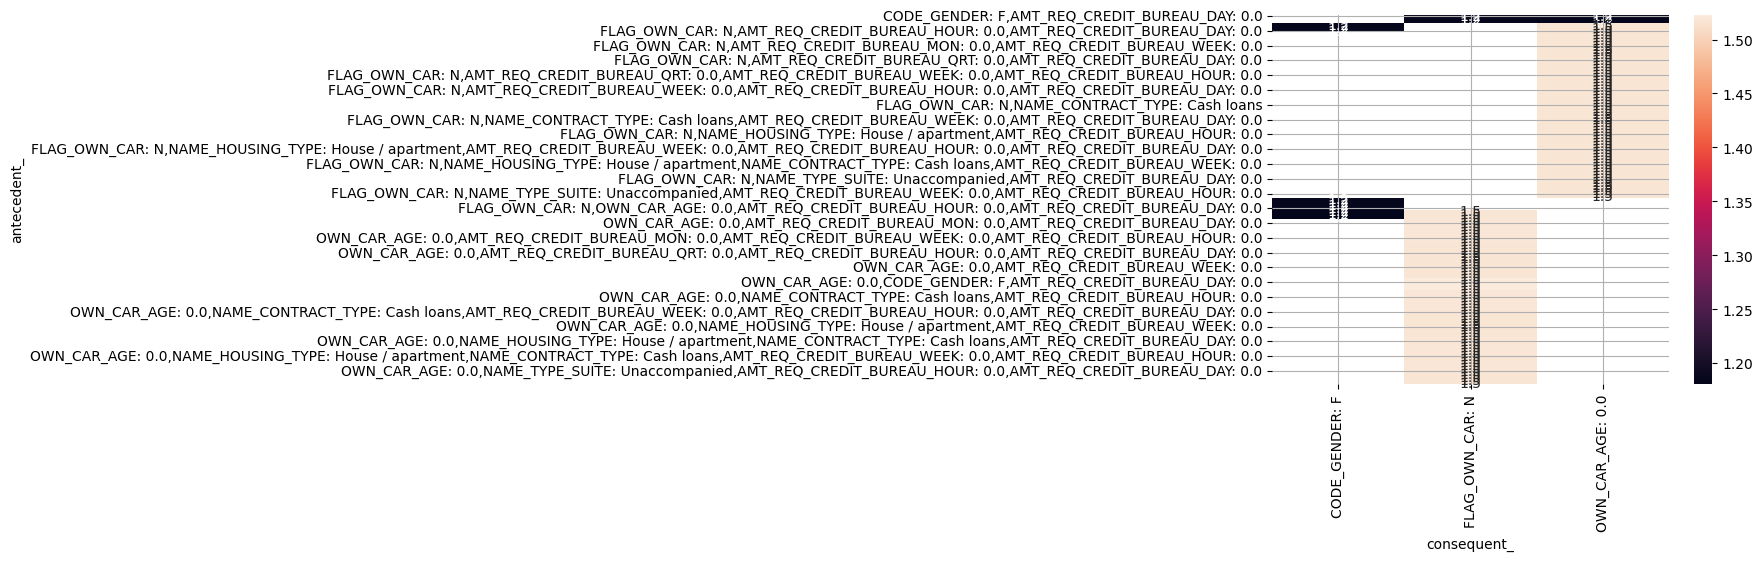

In [40]:
import pandas as pd
rules_df = rules_replaced.toPandas()
rules_df = rules_df[rules_df['lift']>1.1]
pivot = rules_df[rules_df['lhs_items']>1.4].pivot(index = 'antecedent_', 
                    columns = 'consequent_', values= 'lift')

# rules_df.head()
# Generate a heatmap with annotations on
sns.heatmap(pivot, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [29]:
# Find the statistics
max_support = rules_filtered.agg({"support": "max"}).collect()[0][0]
min_support = rules_filtered.agg({"support": "min"}).collect()[0][0]
max_confidence = rules_filtered.agg({"confidence": "max"}).collect()[0][0]
min_confidence = rules_filtered.agg({"confidence": "min"}).collect()[0][0]
max_lift = rules_filtered.agg({"lift": "max"}).collect()[0][0]
min_lift = rules_filtered.agg({"lift": "min"}).collect()[0][0]

print(f"Maximum Support: {max_support:.4f}")
print(f"Minimum Support: {min_support:.4f}")
print(f"Maximum Confidence: {max_confidence:.4f}")
print(f"Minimum Confidence: {min_confidence:.4f}")
print(f"Maximum Lift: {max_lift:.4f}")
print(f"Minimum Lift: {min_lift:.4f}")

Maximum Support: 0.9587
Minimum Support: 0.5004
Maximum Confidence: 1.0000
Minimum Confidence: 0.6292
Maximum Lift: 1.5232
Minimum Lift: 0.9715


<h3>K - means</h3>

In [31]:
# Load your data into a DataFrame
data = app_df

# Identify non-numeric columns
non_numeric_cols = [col for col, dtype in data.dtypes if dtype == 'string']

# Create stages for one-hot encoding
stages = []

for col in non_numeric_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    encoder = OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded")
    stages += [indexer, encoder]

# Assemble feature vectors
feature_cols = [col + "_encoded" for col in non_numeric_cols] + [col for col in data.columns if col not in non_numeric_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
stages += [assembler]

# Create a pipeline
pipeline = Pipeline(stages=stages)
model = pipeline.fit(data)
data_transformed = model.transform(data)

# Select the relevant columns
selected_columns = ["features"] + [col for col in data.columns if col not in non_numeric_cols]
data_transformed = data_transformed.select(selected_columns)

# Show the transformed DataFrame
data_transformed.show(truncate=False)



+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------+----------------+----------+-----------+---------------+----------+-------------+-----------------+---------------+-----------+---------------+-----------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+-------------------+----------------------+--------------------------+------------------------+
|features                                                                                                                                                                                                                  

In [ ]:
#Find silhouette score
k_values = [2, 3, 4, 5]  # Test different values of K
for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(data_transformed)

    # Get the cluster assignments
    predictions = model.transform(data_transformed)

    # Evaluate the clustering using the Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    print(f"For K={k}, Silhouette Score: {silhouette_score}")

For K=2, Silhouette Score: 0.6426911217206026
For K=3, Silhouette Score: 0.5943363775546168
For K=4, Silhouette Score: 0.6349987161830215
For K=5, Silhouette Score: 0.5771661753172697


In [ ]:
#Actual K-Means program
kmeans = KMeans(featuresCol='features',k=2) 
model = kmeans.fit(data_transformed) 
predictions = model.transform(data_transformed)

In [ ]:
#Show cluster diffrences
grouped_data = predictions.groupBy("prediction")

# Define the attributes you want to aggregate
attributes_to_aggregate = [
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "Age",
    "Years_EMPLOYED",
    "Years_REGISTRATION",
    "Years_ID_PUBLISH",
    "OWN_CAR_AGE",
    "CNT_FAM_MEMBERS",
    "HOUR_APPR_PROCESS_START",
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR"
]

# Create aggregation expressions for each attribute
agg_exprs = {attr: "mean" for attr in attributes_to_aggregate}

# Calculate the mean of specified attributes within each cluster
cluster_means = grouped_data.agg(agg_exprs)

# Show the results
cluster_means.show()

+----------+-----------------+---------------------+-----------------+-----------------+----------------------------+------------------------------+-------------------+-----------------------+-------------------+-----------------+---------------------+------------------------------+-------------------------------+------------------------------+--------------------+--------------------+-------------------------------+-------------------------------+
|prediction| avg(AMT_ANNUITY)|avg(Years_ID_PUBLISH)| avg(OWN_CAR_AGE)|  avg(AMT_CREDIT)|avg(HOUR_APPR_PROCESS_START)|avg(AMT_REQ_CREDIT_BUREAU_DAY)|  avg(CNT_CHILDREN)|avg(Years_REGISTRATION)|avg(Years_EMPLOYED)|         avg(Age)|avg(AMT_INCOME_TOTAL)|avg(AMT_REQ_CREDIT_BUREAU_MON)|avg(AMT_REQ_CREDIT_BUREAU_YEAR)|avg(AMT_REQ_CREDIT_BUREAU_QRT)|avg(CNT_FAM_MEMBERS)|avg(AMT_GOODS_PRICE)|avg(AMT_REQ_CREDIT_BUREAU_WEEK)|avg(AMT_REQ_CREDIT_BUREAU_HOUR)|
+----------+-----------------+---------------------+-----------------+-----------------+------